# Boosting com o CoutoBoost

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(7,5)})


In [2]:
df_original = pd.read_csv("tic-tac-toe.data", names=[0, 1, 2, 3, 4, 5, 6, 7, 8, "Result"])
df_original.head()

,0,1,2,3,4,5,6,7,8,Result
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [3]:
print("Exemplos x características: ", (df_original.shape[0], df_original.shape[1]-1))
positive_ratio = len(df_original.loc[df_original["Result"] == "positive"]) / df_original.shape[0]
negative_ratio = 1 - positive_ratio
print(f"Taxa de positivos: {positive_ratio:.2f}")
print(f"Taxa de negativos: {negative_ratio:.2f}")

Exemplos x características:  (958, 9)
Taxa de positivos: 0.65
Taxa de negativos: 0.35


## Preparação dos dados

O algoritmo `CoutoBoostClassifier` implementado é uma versão simplificada do AdaBoost que espera receber as entradas com características binárias e a saída $\epsilon \{-1, +1\}$.



In [4]:
from sklearn.model_selection import train_test_split


# 1. muda a ordem das colunas colocando o label primeiro (para próximo passo)
cols = df_original.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df_original[cols]


# 2. valor numérico para rótulo
df["Result"] = df["Result"].map({
    "positive":  1,
    "negative": -1
})

# 3. transforma cada coluna de feature em 3 colunas binárias
df = pd.get_dummies(df, columns=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# 4. embaralha
df = df.sample(frac=1)

# 5. DataFrame >> ndarray
# 6. X, y
dados = df.to_numpy()
y = dados[:, 0]
X = dados[:, 1:]

# 7. particiona em dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)


## Baseline: AdaBoostClassifier

Para fins de comparação, vamos resolver o problema usando a implementação de AdaBoost do pacote `sklearn.ensemble`.

In [5]:
# configuração do experimento
iterations = 200


In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

clf_baseline = AdaBoostClassifier(n_estimators=iterations)
clf_baseline.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=200)

In [7]:
y_hat_baseline = clf_baseline.predict(X_test)

score_baseline = accuracy_score(y_test, y_hat_baseline)
print(f"Acurácia de AdaBoost({iterations}):", score_baseline)

Acurácia de AdaBoost(200): 0.984375


## CoutoBoost

Similar aos algoritmos do pacote `sklearn`, o `CoutoBoostClassifier` tem em sua interface pública os métodos `fit(X, y)` e `predict(X)`, sendo que este último pode receber um parâmetro `max_estimators` que indica a quantidade de hipóteses, das que foram treinadas, que serão usadas para a classificação. Se omitido, todas as hipóteses serão usadas.

In [8]:
from couto_boost import CoutoBoostClassifier

clf = CoutoBoostClassifier(max_estimators=iterations)
clf.fit(X_train, y_train)

CoutoBoostClassifier(max_estimators=200)

Com o classificador **CoutoBoost** implementado, vamos ver como sua acurácia se comporta de acordo com o número de iterações:

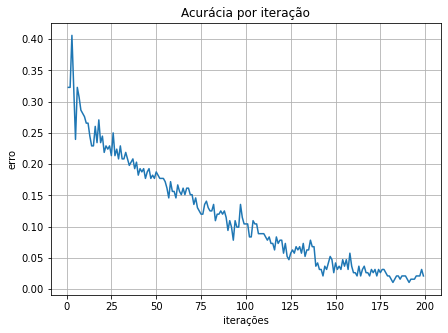

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import zero_one_loss

accuracies = []
errors = []

for max_iterations in np.arange(1, iterations):
    y_hat = clf.predict(X_test, max_estimators=max_iterations)
    score = accuracy_score(y_test, y_hat)
    error = zero_one_loss(y_test, y_hat)
    accuracies.append(score)
    errors.append(error)

# mostra a acurácia ao longo das iterações
fig, ax = plt.subplots()
#ax.plot(np.arange(1, iterations), accuracies)
ax.plot(np.arange(1, iterations), errors)
ax.set(xlabel='iterações', ylabel='erro',
       title='Acurácia por iteração')
ax.grid()



In [10]:
from sklearn.model_selection import cross_val_score

X = np.append(X_train, X_test, axis=0)
y = (np.append(y_train, y_test, axis=0))# + 1) / 2
#scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
#scores.mean()



In [13]:
from sklearn.metrics import auc, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold

def analyze_and_plot_estimator(estimator, estimator_name, X, y):
    """
    Faz (1) validação cruzada, gerando gráfico de curva AOC-ROC e (2) testando nos dados de teste para gerar curva precision-recall
    """
    # 1. curva ROC
    cross_validator = StratifiedKFold(n_splits=5)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f"Análise de {estimator_name}")
    for i, (train, test) in enumerate(cross_validator.split(X, y)):
        estimator.fit(X[train], y[train])
        vizualization = plot_roc_curve(estimator, X[test], y[test], name=f"ROC do fold {i}", alpha=0.3, lw=1, ax=ax1)
        interp_tpr = np.interp(mean_fpr, vizualization.fpr, vizualization.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(vizualization.roc_auc)

    ax1.plot([0, 1], [0, 1], linestyle="--", lw=1, color="r", label="Acaso", alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax1.plot(mean_fpr, mean_tpr, color="b", label=r"ROC média (AUC = %0.4f $\pm$ %0.4f)" % (mean_auc, std_auc), lw=1, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.2,
                    label=r"$\pm$ 1 desvio padrão")
    ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f"Curva ROC")
    ax1.set_ylabel("Taxa de verdadeiros positivos")
    ax1.set_xlabel("Taxa de falsos positivos")
    ax1.legend(loc="lower right")
    for axis in ["top", "bottom", "left", "right"]:
        ax1.spines[axis].set_linewidth(1)
    ax1.tick_params(width=1)
    
    
    # 2. Precisão e revocação em train/test
    visualization = plot_precision_recall_curve(estimator, X, y, ax=ax2, lw=1)
    visualization.ax_.set_title(f"Curva precisão-revocação")

    for axis in ["top", "bottom", "left", "right"]:
        ax2.spines[axis].set_linewidth(1)
    ax2.tick_params(width=1)
    
    
    fig.tight_layout()
    plt.show()
    return dict(mean_fpr=mean_fpr, mean_tpr=mean_tpr, label=r"ROC média (AUC = %0.4f $\pm$ %0.4f) %s" % (mean_auc, std_auc, estimator_name))

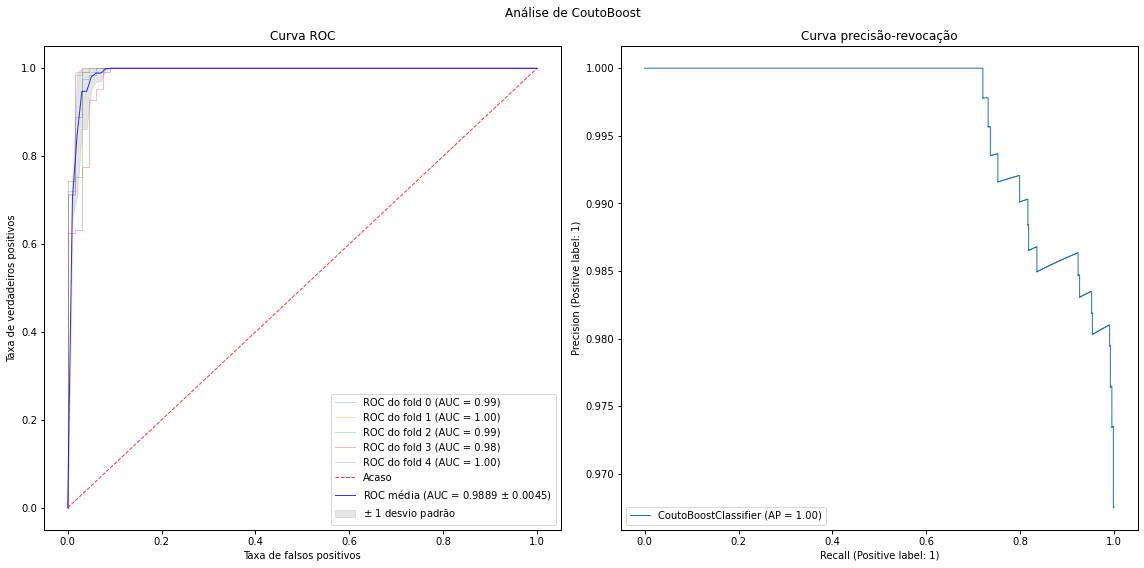

In [14]:
plt.rcParams.update({'figure.figsize':(16,8)})
roc = analyze_and_plot_estimator(clf, "CoutoBoost", X, y)
